# Federated Never Ending Learning

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [3]:
import warnings
warnings.filterwarnings("ignore")

In [4]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import ConfusionMatrixDisplay, classification_report

In [5]:
from tensorflow import keras
from keras.models import Sequential
from keras.layers import Dense

2022-11-21 10:33:55.004044: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-11-21 10:33:55.586131: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/lib64/openmpi/lib
2022-11-21 10:33:55.586173: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
2022-11-21 10:33:55.690371: E tensorflow/stream_executor/cuda/cuda_blas.cc:2981] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2022-11-21 10:33:57.647078:

## Data Preprocessing

In [6]:
df = pd.read_csv('datasets/CICIDS_test.csv', skipinitialspace=True)

In [7]:
from sklearn.preprocessing import MinMaxScaler, Normalizer
# from keras.utils import to_categorical

# # removing any class with less than 'thresh' samples
# thresh = 1000
# counts = df[['Label']].value_counts().to_dict()
# keep = [x[0] for x in counts if counts[x] >= thresh]
# df = df.loc[df['Label'].isin(keep)]


X = df.loc[:, df.columns != 'Label']
X = Normalizer().fit_transform(X)
X = MinMaxScaler().fit_transform(X)
Y = df[['Label']].to_numpy()

In [8]:
print(X.shape)
print(Y.shape)
print(len(np.unique(Y)))
pd.value_counts(Y.ravel())

(566149, 78)
(566149, 1)
15


0     454620
4      46215
10     31786
2      25606
3       2059
7       1588
11      1179
6       1159
5       1100
1        393
12       301
14       130
9          7
13         4
8          2
dtype: int64

## Classification Models

In [9]:
class BinaryClassification:
    def __init__(self, input_dims, layers):
        self.model = Sequential(name="server_model")
        self.model.add(Dense(
            layers[0],
            input_shape=(input_dims,),
            activation='relu'
        ))
        for l in layers[1:]:
            self.model.add(Dense(l, activation='relu'))
        self.model.add(Dense(1, activation='sigmoid'))
        self.model.compile(
            loss='binary_crossentropy',
            optimizer='adam',
            metrics=['accuracy', ]
        )
        self.model.summary()

    # THIS WILL OVERWRITE ANY TRAINING
    def set_avg_weights(self, models):
        all_weights = np.array([
            model.model.get_weights()
                for model in models
        ])
        avg_weights = np.mean(all_weights, axis=0)
        self.model.set_weights(avg_weights)
    
    def fit(self, X, Y, epochs, batch_size):
        Y_bin = np.asarray([
            0 if y == 0 else 1 for y in Y.ravel()
        ]).reshape(-1, 1)
        # print(Y_bin.shape)
        # print(pd.value_counts(Y_bin.ravel()))
        self.model.fit(X, Y_bin, epochs=epochs, batch_size=batch_size)

    def predict(self, X, Y):
        Y_bin = np.asarray([
            0 if y == 0 else 1 for y in Y.ravel()
        ]).reshape(-1, 1)
        # print(pd.value_counts(Y_bin.ravel()))
        
        preds = self.model.predict(X)
        preds = np.where(preds > 0.5, 1, 0)

        # print(Y_bin.shape)
        # print(preds.shape)
        print(classification_report(Y_bin, preds))
        # print(confusion_matrix(Y_bin, preds))
        ConfusionMatrixDisplay.from_predictions(Y_bin, preds)


In [10]:
class MulticlassClassification:
    def __init__(self, input_dims, layers, num_classes):
        self.model = Sequential(name="server_model")
        self.model.add(Dense(
            layers[0],
            input_shape=(input_dims,),
            activation='relu'
        ))
        for l in layers[1:]:
            self.model.add(Dense(l, activation='relu'))
        self.model.add(Dense(num_classes, activation='softmax'))
        self.model.compile(
            loss='sparse_categorical_crossentropy',
            optimizer='adam',
            metrics=['accuracy']
        )
        self.model.summary()

    # THIS WILL OVERWRITE ANY TRAINING
    def set_avg_weights(self, models):
        all_weights = np.array([
            model.model.get_weights()
                for model in models
        ])
        avg_weights = np.mean(all_weights, axis=0)
        self.model.set_weights(avg_weights)

    def fit(self, X, Y, epochs, batch_size):
        # print(pd.value_counts(Y.ravel()))
        self.model.fit(X, Y.ravel(), epochs=epochs, batch_size=batch_size)

    def predict(self, X, Y):
        # print(pd.value_counts(Y.ravel()))
        
        preds = self.model.predict(X)
        preds = [np.argmax(p) for p in preds]
        
        print(classification_report(Y, preds))
        # print(confusion_matrix(Y, preds))
        ConfusionMatrixDisplay.from_predictions(Y, preds)



## Non-Federated

In [11]:
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, train_size=0.7, random_state=1)

print(X_train.shape)
print(Y_train.shape)
print(np.unique(Y_train))
print(pd.value_counts(Y_train.ravel()))

print(X_test.shape)
print(Y_test.shape)
print(np.unique(Y_test))
print(pd.value_counts(Y_test.ravel()))

(396304, 78)
(396304, 1)
[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14]
0     318395
4      32391
10     22137
2      17891
3       1417
7       1123
11       827
6        786
5        780
1        257
12       197
14        92
9          7
13         2
8          2
dtype: int64
(169845, 78)
(169845, 1)
[ 0  1  2  3  4  5  6  7 10 11 12 13 14]
0     136225
4      13824
10      9649
2       7715
3        642
7        465
6        373
11       352
5        320
1        136
12       104
14        38
13         2
dtype: int64


### Binary Classification into Benign/Malicious

In [81]:
model_binary = BinaryClassification(
    input_dims=78,
    layers=[20, 20, 20]
)
model_binary.fit(X_train, Y_train, epochs=10, batch_size=32)

Model: "server_model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_56 (Dense)            (None, 20)                1580      
                                                                 
 dense_57 (Dense)            (None, 20)                420       
                                                                 
 dense_58 (Dense)            (None, 20)                420       
                                                                 
 dense_59 (Dense)            (None, 1)                 21        
                                                                 
Total params: 2,441
Trainable params: 2,441
Non-trainable params: 0
_________________________________________________________________
Epoch 1/10
12385/12385 [==============================] - 35s 3ms/step - loss: 0.1017 - accuracy: 0.9623
Epoch 2/10
12385/12385 [==============================] - 34s 3ms/step - loss: 

5308/5308 [==============================] - 10s 2ms/step
              precision    recall  f1-score   support

           0       1.00      1.00      1.00    136225
           1       0.99      0.98      0.98     33620

    accuracy                           0.99    169845
   macro avg       0.99      0.99      0.99    169845
weighted avg       0.99      0.99      0.99    169845



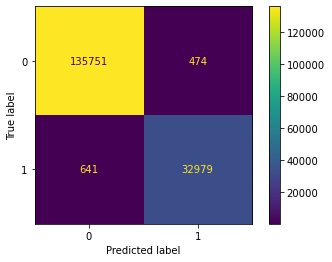

In [82]:
model_binary.predict(X_test, Y_test)

### SoftMax A

In [83]:
model_sf = MulticlassClassification(
    input_dims=78,
    layers=[20, 20, 20],
    num_classes=15
)
model_sf.fit(X_train, Y_train, epochs=10, batch_size=32)

Model: "server_model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_60 (Dense)            (None, 20)                1580      
                                                                 
 dense_61 (Dense)            (None, 20)                420       
                                                                 
 dense_62 (Dense)            (None, 20)                420       
                                                                 
 dense_63 (Dense)            (None, 15)                315       
                                                                 
Total params: 2,735
Trainable params: 2,735
Non-trainable params: 0
_________________________________________________________________
Epoch 1/10
12385/12385 [==============================] - 38s 3ms/step - loss: 0.1828 - accuracy: 0.9467
Epoch 2/10
12385/12385 [==============================] - 37s 3ms/step - loss: 

5308/5308 [==============================] - 10s 2ms/step
              precision    recall  f1-score   support

           0       1.00      1.00      1.00    136225
           1       0.98      0.32      0.49       136
           2       0.96      1.00      0.98      7715
           3       0.94      0.93      0.94       642
           4       0.99      0.98      0.99     13824
           5       0.78      0.75      0.77       320
           6       0.83      0.68      0.75       373
           7       1.00      0.98      0.99       465
          10       0.99      1.00      0.99      9649
          11       0.95      0.90      0.93       352
          12       0.00      0.00      0.00       104
          13       0.00      0.00      0.00         2
          14       0.00      0.00      0.00        38

    accuracy                           0.99    169845
   macro avg       0.72      0.66      0.68    169845
weighted avg       0.99      0.99      0.99    169845



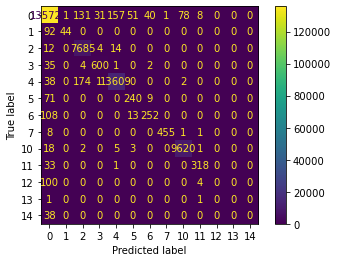

In [84]:
model_sf.predict(X_test, Y_test)

## Federated Learning

In [11]:
X_1, X_2, Y_1, Y_2 = train_test_split(X_train, Y_train, train_size=0.5, random_state=1)

In [12]:
print(X_1.shape)
print(Y_1.shape)
print(np.unique(Y_1))
print(pd.value_counts(Y_1.ravel()))
print(X_2.shape)
print(Y_2.shape)
print(np.unique(Y_2))
print(pd.value_counts(Y_2.ravel()))

(198152, 78)
(198152, 1)
[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14]
0     158990
4      16294
10     11120
2       8918
3        735
7        561
11       440
5        409
6        392
1        139
12        99
14        51
9          2
8          1
13         1
dtype: int64
(198152, 78)
(198152, 1)
[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14]
0     159405
4      16097
10     11017
2       8973
3        682
7        562
6        394
11       387
5        371
1        118
12        98
14        41
9          5
8          1
13         1
dtype: int64


### Binary Classification

In [87]:
model_1 = BinaryClassification(78, [20, 20, 20])
model_1.fit(X_1, Y_1, epochs=10, batch_size=32)

Model: "server_model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_64 (Dense)            (None, 20)                1580      
                                                                 
 dense_65 (Dense)            (None, 20)                420       
                                                                 
 dense_66 (Dense)            (None, 20)                420       
                                                                 
 dense_67 (Dense)            (None, 1)                 21        
                                                                 
Total params: 2,441
Trainable params: 2,441
Non-trainable params: 0
_________________________________________________________________
Epoch 1/10
6193/6193 [==============================] - 19s 3ms/step - loss: 0.1293 - accuracy: 0.9489
Epoch 2/10
6193/6193 [==============================] - 18s 3ms/step - loss: 0.06

5308/5308 [==============================] - 11s 2ms/step
              precision    recall  f1-score   support

           0       0.99      1.00      1.00    136225
           1       0.98      0.98      0.98     33620

    accuracy                           0.99    169845
   macro avg       0.99      0.99      0.99    169845
weighted avg       0.99      0.99      0.99    169845



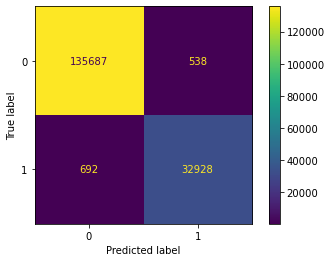

In [88]:
model_1.predict(X_test, Y_test)

In [89]:
model_2 = BinaryClassification(78, [20, 20, 20])
model_2.fit(X_2, Y_2, epochs=10, batch_size=32)

Model: "server_model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_68 (Dense)            (None, 20)                1580      
                                                                 
 dense_69 (Dense)            (None, 20)                420       
                                                                 
 dense_70 (Dense)            (None, 20)                420       
                                                                 
 dense_71 (Dense)            (None, 1)                 21        
                                                                 
Total params: 2,441
Trainable params: 2,441
Non-trainable params: 0
_________________________________________________________________
Epoch 1/10
6193/6193 [==============================] - 18s 3ms/step - loss: 0.1230 - accuracy: 0.9534
Epoch 2/10
6193/6193 [==============================] - 17s 3ms/step - loss: 0.06

5308/5308 [==============================] - 10s 2ms/step
              precision    recall  f1-score   support

           0       1.00      0.99      0.99    136225
           1       0.98      0.98      0.98     33620

    accuracy                           0.99    169845
   macro avg       0.99      0.99      0.99    169845
weighted avg       0.99      0.99      0.99    169845



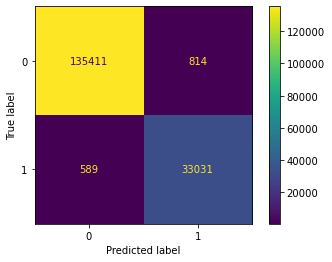

In [90]:
model_2.predict(X_test, Y_test)

In [91]:
model_3 = BinaryClassification(78, [20, 20, 20])
model_3.set_avg_weights([model_1, model_2])

Model: "server_model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_72 (Dense)            (None, 20)                1580      
                                                                 
 dense_73 (Dense)            (None, 20)                420       
                                                                 
 dense_74 (Dense)            (None, 20)                420       
                                                                 
 dense_75 (Dense)            (None, 1)                 21        
                                                                 
Total params: 2,441
Trainable params: 2,441
Non-trainable params: 0
_________________________________________________________________


5308/5308 [==============================] - 9s 2ms/step
              precision    recall  f1-score   support

           0       0.87      0.89      0.88    136225
           1       0.50      0.44      0.47     33620

    accuracy                           0.80    169845
   macro avg       0.68      0.66      0.67    169845
weighted avg       0.79      0.80      0.80    169845



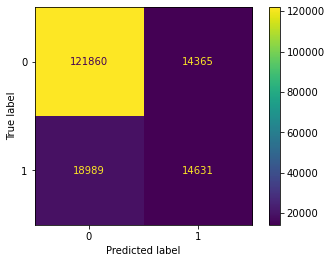

In [92]:
model_3.predict(X_test, Y_test)

### Multiclass Classification

In [24]:
model_sf_1 = MulticlassClassification(
    78,
    [20, 20, 20],
    num_classes=15
)
model_sf_1.fit(X_1, Y_1, epochs=10, batch_size=32)

Model: "server_model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_8 (Dense)             (None, 20)                1580      
                                                                 
 dense_9 (Dense)             (None, 20)                420       
                                                                 
 dense_10 (Dense)            (None, 20)                420       
                                                                 
 dense_11 (Dense)            (None, 15)                315       
                                                                 
Total params: 2,735
Trainable params: 2,735
Non-trainable params: 0
_________________________________________________________________


2022-11-21 10:27:48.743392: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 61823424 exceeds 10% of free system memory.


Epoch 1/10
6193/6193 [==============================] - 20s 3ms/step - loss: 0.2456 - accuracy: 0.9264
Epoch 2/10
6193/6193 [==============================] - 17s 3ms/step - loss: 0.1108 - accuracy: 0.9674
Epoch 3/10
6193/6193 [==============================] - 18s 3ms/step - loss: 0.0822 - accuracy: 0.9796
Epoch 4/10
6193/6193 [==============================] - 17s 3ms/step - loss: 0.0692 - accuracy: 0.9823
Epoch 5/10
6193/6193 [==============================] - 17s 3ms/step - loss: 0.0602 - accuracy: 0.9851
Epoch 6/10
6193/6193 [==============================] - 17s 3ms/step - loss: 0.0545 - accuracy: 0.9863
Epoch 7/10
6193/6193 [==============================] - 18s 3ms/step - loss: 0.0504 - accuracy: 0.9874
Epoch 8/10
6193/6193 [==============================] - 19s 3ms/step - loss: 0.0464 - accuracy: 0.9884
Epoch 9/10
6193/6193 [==============================] - 18s 3ms/step - loss: 0.0434 - accuracy: 0.9893
Epoch 10/10
6193/6193 [==============================] - 19s 3ms/step - l

5308/5308 [==============================] - 12s 2ms/step
              precision    recall  f1-score   support

           0       0.99      1.00      0.99    136225
           1       1.00      0.33      0.50       136
           2       0.97      0.99      0.98      7715
           3       0.90      0.96      0.93       642
           4       0.98      0.97      0.98     13824
           5       0.77      0.71      0.74       320
           6       0.81      0.66      0.73       373
           7       1.00      0.86      0.92       465
          10       0.99      1.00      0.99      9649
          11       0.96      0.89      0.92       352
          12       0.00      0.00      0.00       104
          13       0.00      0.00      0.00         2
          14       0.00      0.00      0.00        38

    accuracy                           0.99    169845
   macro avg       0.72      0.64      0.67    169845
weighted avg       0.99      0.99      0.99    169845



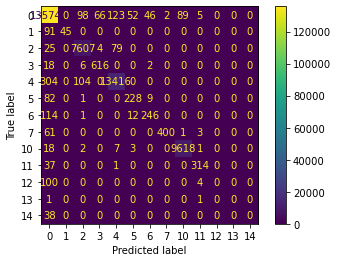

In [94]:
model_sf_1.predict(X_test, Y_test)

In [95]:
model_sf_2 = MulticlassClassification(
    78,
    [20, 20, 20],
    num_classes=15
)
model_sf_2.fit(X_2, Y_2, epochs=10, batch_size=32)

Model: "server_model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_80 (Dense)            (None, 20)                1580      
                                                                 
 dense_81 (Dense)            (None, 20)                420       
                                                                 
 dense_82 (Dense)            (None, 20)                420       
                                                                 
 dense_83 (Dense)            (None, 15)                315       
                                                                 
Total params: 2,735
Trainable params: 2,735
Non-trainable params: 0
_________________________________________________________________
Epoch 1/10
6193/6193 [==============================] - 17s 3ms/step - loss: 0.2404 - accuracy: 0.9251
Epoch 2/10
6193/6193 [==============================] - 16s 3ms/step - loss: 0.11

5308/5308 [==============================] - 9s 2ms/step
              precision    recall  f1-score   support

           0       0.99      0.99      0.99    136225
           1       0.96      0.37      0.53       136
           2       0.96      0.99      0.97      7715
           3       0.97      0.69      0.81       642
           4       0.97      0.97      0.97     13824
           5       0.77      0.65      0.70       320
           6       0.87      0.66      0.75       373
           7       0.99      0.91      0.95       465
          10       0.98      1.00      0.99      9649
          11       0.92      0.97      0.95       352
          12       0.00      0.00      0.00       104
          13       0.00      0.00      0.00         2
          14       0.00      0.00      0.00        38

    accuracy                           0.99    169845
   macro avg       0.72      0.63      0.66    169845
weighted avg       0.99      0.99      0.99    169845



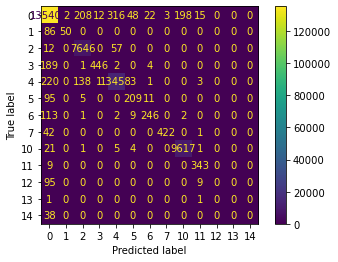

In [96]:
model_sf_2.predict(X_test, Y_test)

In [97]:
model_sf_3 = MulticlassClassification(
    78,
    [20, 20, 20],
    num_classes=15
)
model_sf_3.set_avg_weights([model_sf_1, model_sf_2])

Model: "server_model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_84 (Dense)            (None, 20)                1580      
                                                                 
 dense_85 (Dense)            (None, 20)                420       
                                                                 
 dense_86 (Dense)            (None, 20)                420       
                                                                 
 dense_87 (Dense)            (None, 15)                315       
                                                                 
Total params: 2,735
Trainable params: 2,735
Non-trainable params: 0
_________________________________________________________________


5308/5308 [==============================] - 10s 2ms/step
              precision    recall  f1-score   support

           0       0.81      1.00      0.89    136225
           1       0.00      0.00      0.00       136
           2       0.12      0.00      0.00      7715
           3       0.00      0.00      0.00       642
           4       0.00      0.00      0.00     13824
           5       0.00      0.00      0.00       320
           6       0.00      0.00      0.00       373
           7       0.00      0.00      0.00       465
          10       0.01      0.00      0.00      9649
          11       0.00      0.00      0.00       352
          12       0.00      0.00      0.00       104
          13       0.00      0.00      0.00         2
          14       0.00      0.00      0.00        38

    accuracy                           0.80    169845
   macro avg       0.07      0.08      0.07    169845
weighted avg       0.66      0.80      0.72    169845



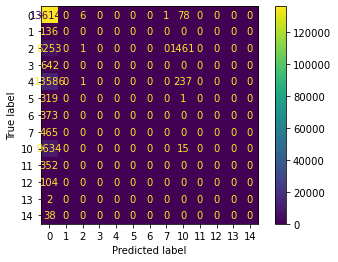

In [98]:
model_sf_3.predict(X_test, Y_test)


## Never Ending Learning
### Anomaly Detection Using Isolation Forest

In [14]:
from sklearn.ensemble import IsolationForest

isf = IsolationForest(random_state=1)
isf.fit(X)

IsolationForest(random_state=1)

In [20]:
preds = isf.predict(X_train)

In [22]:
num_anomaly = len([p for p in preds if p == -1])
print(f"{num_anomaly} anomalies found")

23100 anomalies found
